In [243]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import argparse
import os

# Leave this --> it solves the OMP issue
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torchquantum as tq
import torchquantum.functional as tqf

import torchvision.datasets as datasets
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector
from qiskit import transpile
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_histogram

# import basic plot tools
from qiskit.visualization import plot_histogram

In [244]:
'''
# Define your own operator/oracle
# Leave Here as a reminder

name_of_newgate = 'magic_operator'
number_of_qubits = 2
controls = QuantumRegister(number_of_qubits)
circuit = QuantumCircuit(controls)

operatorName = Operator([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

# Add to a circuit

my_circuit.unitary(operatorName, list(range(number_of_qubits)),name_of_newgate)
'''

"\n# Define your own operator/oracle\n# Leave Here as a reminder\n\nname_of_newgate = 'magic_operator'\nnumber_of_qubits = 2\ncontrols = QuantumRegister(number_of_qubits)\ncircuit = QuantumCircuit(controls)\n\noperatorName = Operator([\n    [1, 0, 0, 0],\n    [0, 1, 0, 0],\n    [0, 0, 1, 0],\n    [0, 0, 0, 1]\n])\n\n# Add to a circuit\n\nmy_circuit.unitary(operatorName, list(range(number_of_qubits)),name_of_newgate)\n"

In [252]:
class CustomCircuit:
    def __init__(self, name, draw_mode='bloch', simulate=False):
        self.name = name
        self.num_states = 0
        self.simulate = simulate
        self.circuit = self.build_circuit()
        self.add_new_state()
        self.draw_mode = draw_mode

    def __call__(self):
        return self.circuit.draw()

    def build_circuit(self):
        self.nq = 2
        q = QuantumRegister(self.nq)
        qc = QuantumCircuit(q)
        qc.h(q[0])
        qc.h(q[1])
        qc.p(np.pi/2,q)
        return qc

    def simulation(self):
        meas = QuantumCircuit(self.nq, self.nq)
        meas.barrier(range(self.nq))
        meas.measure(range(self.nq), range(self.nq))
        qc = meas.compose(self.circuit, range(self.nq), front=True)
        qc.barrier(range(self.nq))
        backend = AerSimulator()
        qc_compiled = transpile(qc, backend)
        job_sim = backend.run(qc_compiled, shots=1024)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(qc_compiled)
        return plot_histogram(counts)

    def evolve(self, state_id=None, draw=True):
        assert self.num_states > 0, 'No states found'
        state_id = self.num_states-1 if state_id is None else state_id
        self.state_evolved[state_id] = self.state_init[state_id].evolve(self.circuit)
        if draw:
            return self.state_evolved[state_id].draw(self.draw_mode)

    def add_new_state(self, up=False):
        self.state_init = {}
        self.state_evolved = {}
        self.state_init[self.num_states] = Statevector.from_int(1 if up else 0, 2**self.nq)
        self.num_states += 1


In [247]:
circ = CustomCircuit('my_circ', 'qsphere', True)
circ()

┌───┐┌────────┐
q185_0: ┤ H ├┤ P(π/2) ├
        ├───┤├────────┤
q185_1: ┤ H ├┤ P(π/2) ├
        └───┘└────────┘

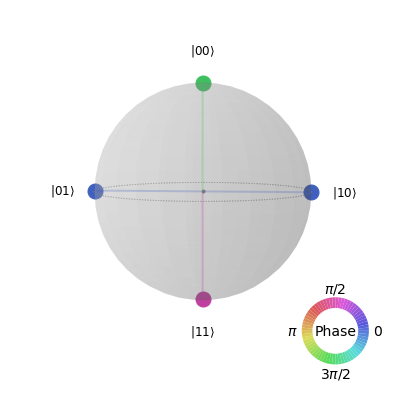

In [233]:
circ.evolve()

In [242]:
circ.state_evolved[0].draw('latex')

<IPython.core.display.Latex object>

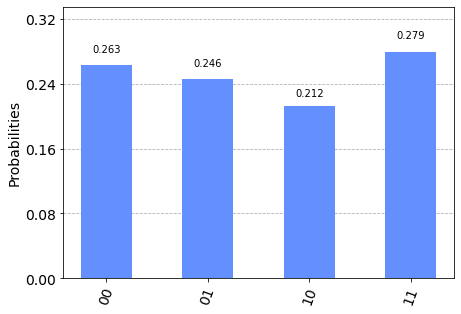

In [220]:
circ.simulation()